# Deep Learning Audio Classifier
This project is the Z by HP Challenge 3. The objective is to analyze audio files and determine which areas of the forest have the greatest density of Capuchin Birds based on the frequency of bird calls in a given audio clip.

To do so a keras CNN was built and trained to identify the capuchin calls in each forest recording.

### Importing and Installing Dependencies

In [3]:
%pip install tensorflow tensorflow-io matplotlib


Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

2024-01-15 07:09:29.328419: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/sohammehra/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Building Data Loading Function

In [5]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [6]:
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)

    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)

    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)

    return wav

In [7]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN)

2024-01-15 07:09:34.419172: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX AVX2 AVX512F FMA


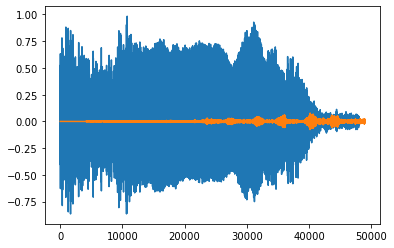

In [8]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

### Creating Tensorflow Dataset

In [9]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

In [10]:

#Listing all '.wav' files in the POS directory
pos = tf.data.Dataset.list_files(str(POS + '*/*.wav'))
#Listing all '.wav' files in the NEG directory
neg = tf.data.Dataset.list_files(NEG + '*/*.wav')

pos.as_numpy_iterator().next()

b'data/Parsed_Capuchinbird_Clips/XC9221-1.wav'

In [11]:
#Labeling the data. Clips with Capuchin calls are labeled as 1 and clips without are labeled as 0
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
#concatinating the data to create one complete dataset
data  = positives.concatenate(negatives)

### Determining average length of capuchin call

In [12]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [13]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [14]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [15]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

### Building Preprocessing Function to Convert to Spectrogram

In [16]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    #Given the min an max of the calls were 32000 and 80000, we went with processing 48000 at a time
    wav = wav[:4800]
    #Padding the tensor with zeros if the length is less than 48000
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    #reformatting and returning the spectrogram
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label


In [17]:
filepath, label = data.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
spectrogram

<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
array([[[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       ...,

       [[2.9269904e-02],
        [3.8667087e-02],
        [4.9527425e-02],
        ...,
        [8.4980633e-07],
        [5.9523683e-07],
        [1.0430813e-07]],

       [[4.1061901e-02],
        [4.7951397e-02],
        [3.9553426e-02],
        ...,
        [4.8868441e-07],
        [2.5775435e-07],
        [7.3760748e-07]],

       [[2.5269389e-02],
        [4.7879402e-02],
        [5.7363037e-02],
        ...,
        [4.5479163

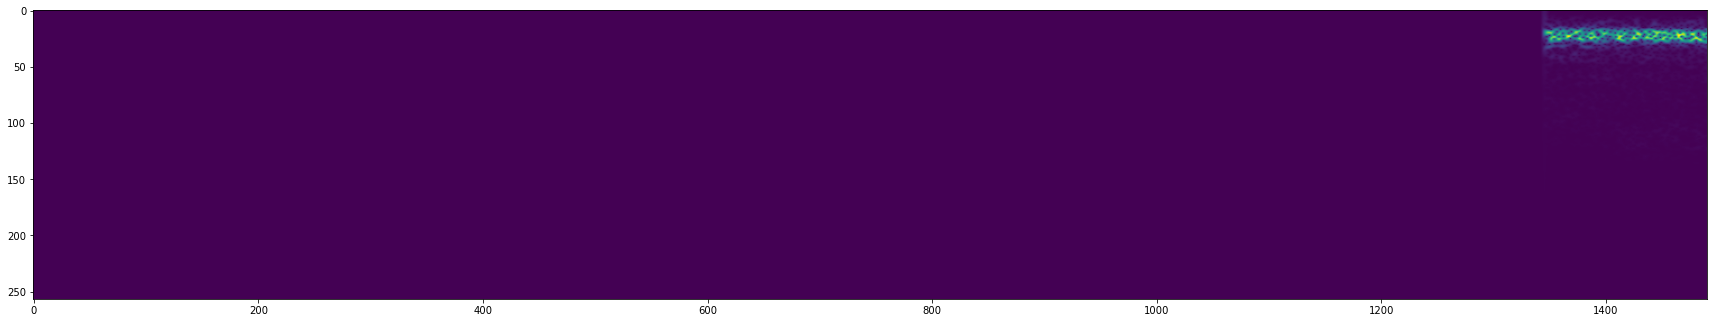

In [18]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

### Creating Training and Testing Partitions

In [19]:
#Preprocessing, batching, and shuffling dataset
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [20]:
len(data) * 0.7

35.699999999999996

In [21]:
#Splitting train and test data with 70/30 split
train = data.take(36)
test = data.skip(36).take(15)

In [22]:
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

### Building the Deep Learning Model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [24]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [25]:
model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770482865 (2.87 GB)
Trainable params: 770482865 (2.87 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Fitting Model, Viewing Loss, Plotting KPIs

In [27]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4


36/36 [==============================] - 1823s 51s/step - loss: 0.9934 - recall: 0.6194 - precision: 0.6443 - val_loss: 0.2117 - val_recall: 0.8852 - val_precision: 0.7606
Epoch 2/4
36/36 [==============================] - 2436s 68s/step - loss: 0.2144 - recall: 0.8742 - precision: 0.8462 - val_loss: 0.2210 - val_recall: 0.9275 - val_precision: 0.9143
Epoch 3/4
36/36 [==============================] - 2248s 62s/step - loss: 0.1714 - recall: 0.8456 - precision: 0.9618 - val_loss: 0.1744 - val_recall: 0.9123 - val_precision: 0.9811
Epoch 4/4
36/36 [==============================] - 2122s 59s/step - loss: 0.1774 - recall: 0.9320 - precision: 0.9013 - val_loss: 0.1044 - val_recall: 0.9508 - val_precision: 0.9062


In [28]:
hist.history

{'loss': [0.9933543801307678,
  0.214384526014328,
  0.17136280238628387,
  0.1773715615272522],
 'recall': [0.6193548440933228,
  0.8741722106933594,
  0.8456375598907471,
  0.9319728016853333],
 'precision': [0.6442952752113342,
  0.8461538553237915,
  0.9618320465087891,
  0.9013158082962036],
 'val_loss': [0.211724653840065,
  0.22104954719543457,
  0.1744391918182373,
  0.10436783730983734],
 'val_recall': [0.8852459192276001,
  0.9275362491607666,
  0.9122806787490845,
  0.9508196711540222],
 'val_precision': [0.7605633735656738,
  0.9142857193946838,
  0.9811320900917053,
  0.90625]}

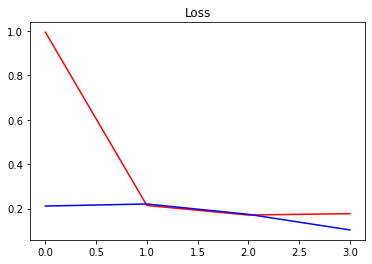

In [29]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

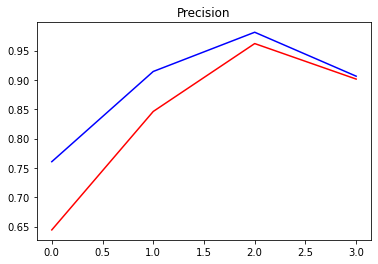

In [31]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

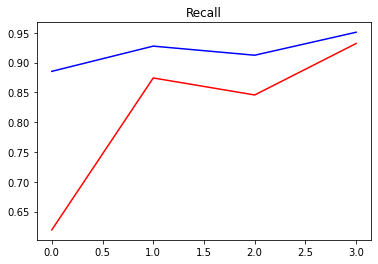

In [33]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

### Checking predictions on a single clip

In [34]:
X_test, y_test = test.as_numpy_iterator().next()
yhat = model.predict(X_test)
yhat

1/1 [==============================] - 3s 3s/step


array([[1.6207730e-02],
       [1.0000000e+00],
       [6.1019342e-02],
       [5.1493521e-10],
       [3.0101002e-03],
       [5.6996800e-02],
       [9.9950916e-01],
       [4.1368484e-01],
       [1.1459527e-03],
       [3.9587967e-02],
       [9.9578482e-01],
       [2.8384358e-04],
       [7.2158969e-07],
       [1.0000000e+00],
       [1.7798604e-05],
       [8.3754455e-13]], dtype=float32)

In [35]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [36]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

### Building Forest Parsing Functions

In [37]:
#Function loads in forest recordings
def load_mp3_16k_mono(filename):
    res = tfio.audio.AudioIOTensor(filename)
    #convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2

    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)

    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [38]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')
wav = load_mp3_16k_mono(mp3)
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [39]:
len(audio_slices)

60

In [40]:
samples, index = audio_slices.as_numpy_iterator().next()
samples.shape

(1, 48000)

In [41]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample], 0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [42]:
#Splits loaded file in to audio segments to predict and processes the data
audio_slices =tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [43]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

1/1 [==============================] - 4s 4s/step


In [44]:
from itertools import groupby

In [45]:
# Groups consecutive predictions as 1 bird call
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()
calls

4

### Making Predictions

In [46]:
#Loops through all forest recordings, slices audio and stores prediction
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data', 'Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

1/1 [==============================] - 3s 3s/step


In [48]:
results

{'recording_95.mp3': array([[3.49605034e-09],
        [3.14624132e-10],
        [9.94828165e-01],
        [4.34631230e-34],
        [5.40662537e-09],
        [8.55568914e-12],
        [4.39884133e-07],
        [1.23410961e-08],
        [7.95266988e-06],
        [1.66505211e-04],
        [7.86377934e-15],
        [1.47044705e-08],
        [2.49319049e-14],
        [2.25656191e-12],
        [3.03027071e-19],
        [5.70504616e-17],
        [8.46121673e-10],
        [3.89753829e-09],
        [3.30699002e-09],
        [3.25006397e-07],
        [1.31658628e-10],
        [4.84475571e-10],
        [4.03343670e-08],
        [4.41100019e-06],
        [3.59548036e-09],
        [1.74179903e-07],
        [4.37785502e-06],
        [5.48460946e-07],
        [2.25317404e-11],
        [2.01098501e-07],
        [2.04450235e-08],
        [3.56645224e-09],
        [9.95622993e-01],
        [2.14860439e-33],
        [4.92229812e-10],
        [1.97227065e-12],
        [3.38433097e-07],
        [1.3270623

In [49]:
#Converts model output to binary classification 
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_95.mp3': [0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0],
 'recording_81.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_56.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0],
 'recording_42.mp3': [0,
  0,
  0,
  

In [50]:
#Groups consecutive bird calls in each file
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_95.mp3': 3,
 'recording_81.mp3': 2,
 'recording_56.mp3': 7,
 'recording_42.mp3': 0,
 'recording_43.mp3': 4,
 'recording_57.mp3': 1,
 'recording_80.mp3': 1,
 'recording_94.mp3': 1,
 'recording_82.mp3': 0,
 'recording_96.mp3': 0,
 'recording_69.mp3': 1,
 'recording_41.mp3': 0,
 'recording_55.mp3': 0,
 'recording_54.mp3': 2,
 'recording_40.mp3': 1,
 'recording_68.mp3': 0,
 'recording_97.mp3': 0,
 'recording_83.mp3': 0,
 'recording_87.mp3': 13,
 'recording_93.mp3': 2,
 'recording_44.mp3': 1,
 'recording_50.mp3': 0,
 'recording_78.mp3': 8,
 'recording_79.mp3': 0,
 'recording_51.mp3': 1,
 'recording_45.mp3': 1,
 'recording_92.mp3': 0,
 'recording_86.mp3': 7,
 'recording_90.mp3': 0,
 'recording_84.mp3': 6,
 'recording_53.mp3': 0,
 'recording_47.mp3': 4,
 'recording_46.mp3': 7,
 'recording_52.mp3': 0,
 'recording_85.mp3': 0,
 'recording_91.mp3': 0,
 'recording_09.mp3': 0,
 'recording_35.mp3': 0,
 'recording_21.mp3': 0,
 'recording_20.mp3': 0,
 'recording_34.mp3': 2,
 'recording_08.

### Exporting Results

In [51]:
import csv

In [52]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])